In [41]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from scipy import stats as ss

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style

# Configuración matplotlib
# ==============================================================================
%matplotlib inline 
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Varios
# ==============================================================================
from tqdm import tqdm

In [47]:
day_one = [138, 130, 135, 140, 120, 125, 120, 130, 130, 144, 143, 140, 130, 150]
day_two = [116, 120, 125, 110, 120, 135, 124, 118, 120, 130, 140, 140, 130, 138]
alpha = 0.05

datos = {
    'day_one': day_one,
    'day_two': day_two
}

datos = pd.DataFrame(datos)

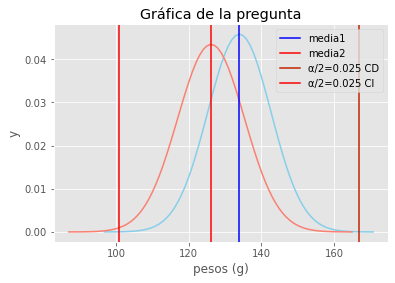

In [45]:
# Gráfica de referencia para las colas
mu1, sigma1 = np.mean(datos.day_one), np.std(datos.day_one)
mu2, sigma2 = np.mean(datos.day_two), np.std(datos.day_two)

X = ss.norm(mu1, sigma1)
Y = ss.norm(mu2, sigma2)

graph1 = np.arange(X.ppf(0.00001), X.ppf(0.99999))
graph2 = np.arange(Y.ppf(0.00001), Y.ppf(0.99999))

plt.plot(graph1, X.pdf(graph1), c='skyblue')
plt.plot(graph2, Y.pdf(graph2), c='salmon')

tail_left = int(graph1.size * 0.05) + 1
tail_right = int(graph1.size * 0.95) - 1

plt.axvline(mu1, c='blue', label='media1')
plt.axvline(mu2, c='red', label='media2')
plt.axvline(graph1[tail_right], c='#c02200', label='α/2=0.025 CD')
plt.axvline(graph1[tail_left], c='#f80000', label='α/2=0.025 CI')

plt.title('Gráfica de la pregunta')
plt.ylabel('y')
plt.xlabel('pesos (g)')

plt.legend()

In [46]:
def test_t(x1, x2, std1, std2, n1, n2):
    
    return ((x1 - x2) - 0) / np.sqrt(std1 ** 2 / n1 + std2 ** 2 / n2)

In [49]:
datos.describe()

,day_one,day_two
count,14.000000,14.000000
mean,133.928571,126.142857
std,9.042330,9.534207
min,120.000000,110.000000
25%,130.000000,120.000000
50%,132.500000,124.500000
75%,140.000000,133.750000
max,150.000000,140.000000


In [56]:
t, p_value = ss.ttest_rel(datos.day_one, datos.day_two)

print('El estadistico de prueba "t" es:', t)
print('El p-valor es: ', p_value)

El estadistico de prueba "t" es: 2.7637379337772026
El p-valor es:  0.016109284422067667
